In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)


In [3]:
from initialization import DatasetInitializer, IdentityInitializer
from layers import DiscriminationModule, ClassificationModule
from loading import SequentialLoader
from metrics import Conncetedness, Consistency

metric1 = Conncetedness()
metric2 = Consistency()
loader = SequentialLoader(mnist_data, num_classes=10)


In [4]:
train_size = 500
precisions = []
recalls = []
consistencies = []

for epoch in range(100, 600, 100):
    metric1.reset()
    metric2.reset()
    
    precision = []
    recall = []
    consistency = []
    
    beta = 1 - (1/epoch)
    module_d = DiscriminationModule(500, DatasetInitializer(dataset=mnist_data, num_classes=10), beta=beta)
    module_c = ClassificationModule(500, IdentityInitializer())
    
    for epoch_number in tqdm(range(train_size//epoch), desc=str(epoch)):
        module_c.teaching('on') if epoch_number == 0 else module_c.teaching('off')
        for x in loader(epoch):
            y_ = module_d(x)
            module_c(y_)
        
        module_d.organize()
        module_c.organize()
        metric1.update(module_c.recurrent_weights, module_d.labels(10))
        metric2.update(module_d.labels(10))
        
        p, r = metric1.compute()
        c = metric2.compute()
        precision.append(p)
        recall.append(r)
        consistency.append(c)
    
    precisions.append(precision)
    recalls.append(recall)
    consistencies.append(consistency)

500: 100%|██████████| 10/10 [12:15<00:00, 73.57s/it]


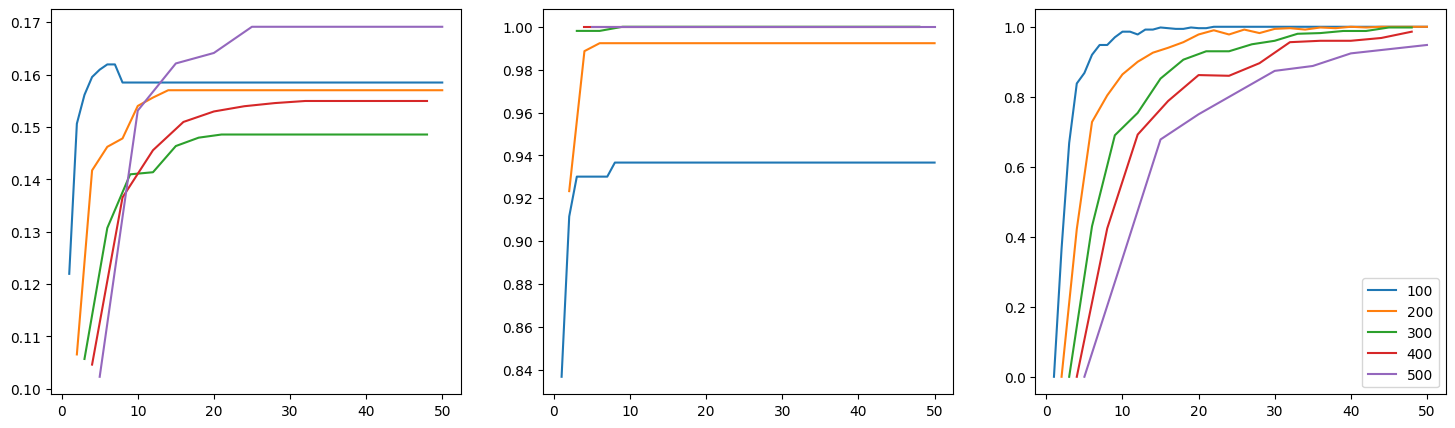

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
for i in range(5):
    x = [*range(i+1, train_size//100+1, i+1)]
    ax[0].plot(x, precisions[i], label=str(100*(i+1)))
    ax[1].plot(x, recalls[i], label=str(100*(i+1)))
    ax[2].plot(x, consistencies[i], label=str(100*(i+1)))
plt.legend()

In [55]:
train_size = 10000
epochs = [300]*5 + [200]*10 + [100]*15 + [50]*30 + [150]*40
#epochs = [50]*200
precisions = []
recalls = []
consistency = []
pruned_weights = []
beta = 1 - 1/300
#t_counter = 0

module_d = DiscriminationModule(500, DatasetInitializer(mnist_data, num_classes=10), beta=beta, alpha=1.2)
module_c = ClassificationModule(500, IdentityInitializer(), pruner_alpha=4)
#module_c.pruning('on')

for eidx, epoch in tqdm(enumerate(epochs), total=len(epochs)):
    metric1.reset()
    for x in loader(epoch):
        y_ = module_d(x)
        y = module_c(y_)
        
    module_d.organize() 
    module_c.organize()
    if eidx > 70:
        module_c.pruning('on')
        #pruned_weights.append(module_c.pruned_weights)
    #module_c.pruning('on') if eidx > 60 else None
    #module_c.teach() if eidx > 0 and eidx%10 == 0 else None
    metric1.update(module_c.recurrent_weights, module_d.labels(10))
    metric2.update(module_d.labels(10))
    p, r = metric1.compute()
    precisions.append(p)
    recalls.append(r)
    consistency.append(metric2.compute())
    
#print(f"{t_counter=}")

100%|██████████| 100/100 [28:29<00:00, 17.10s/it]


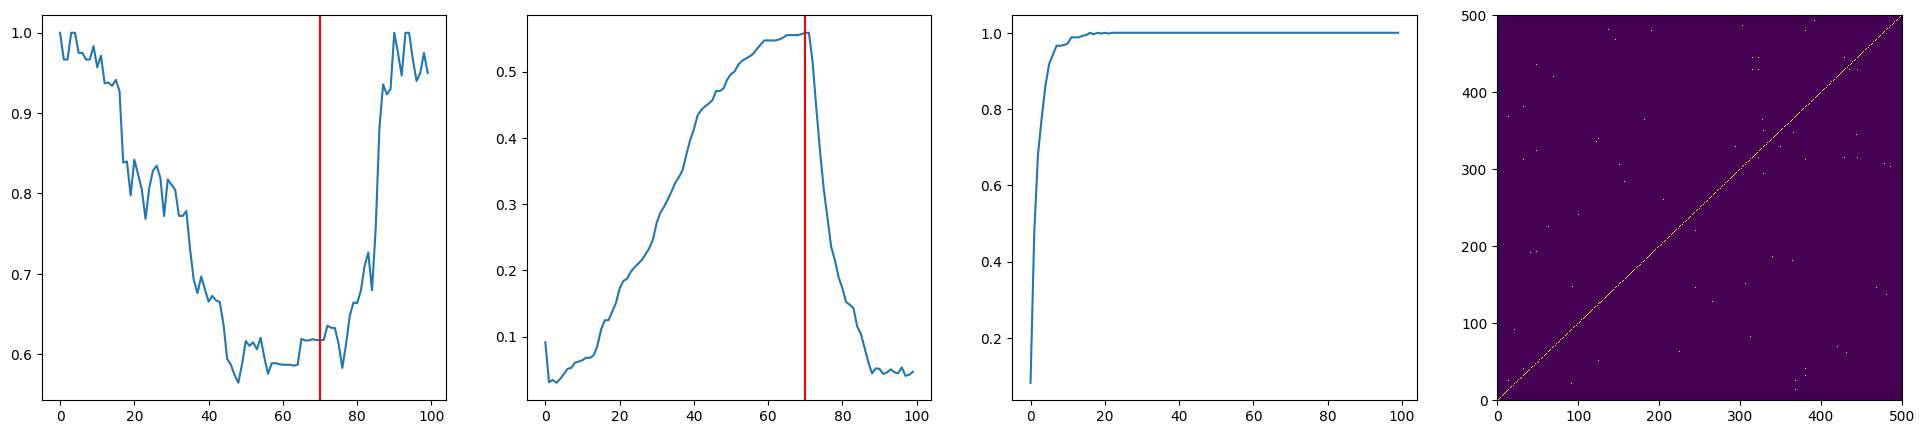

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
ax[0].plot(precisions); ax[0].axvline(70, color='r')
ax[1].plot(recalls); ax[1].axvline(70, color='r')
ax[2].plot(consistency)
ax[3].pcolormesh(module_c.recurrent_weights)

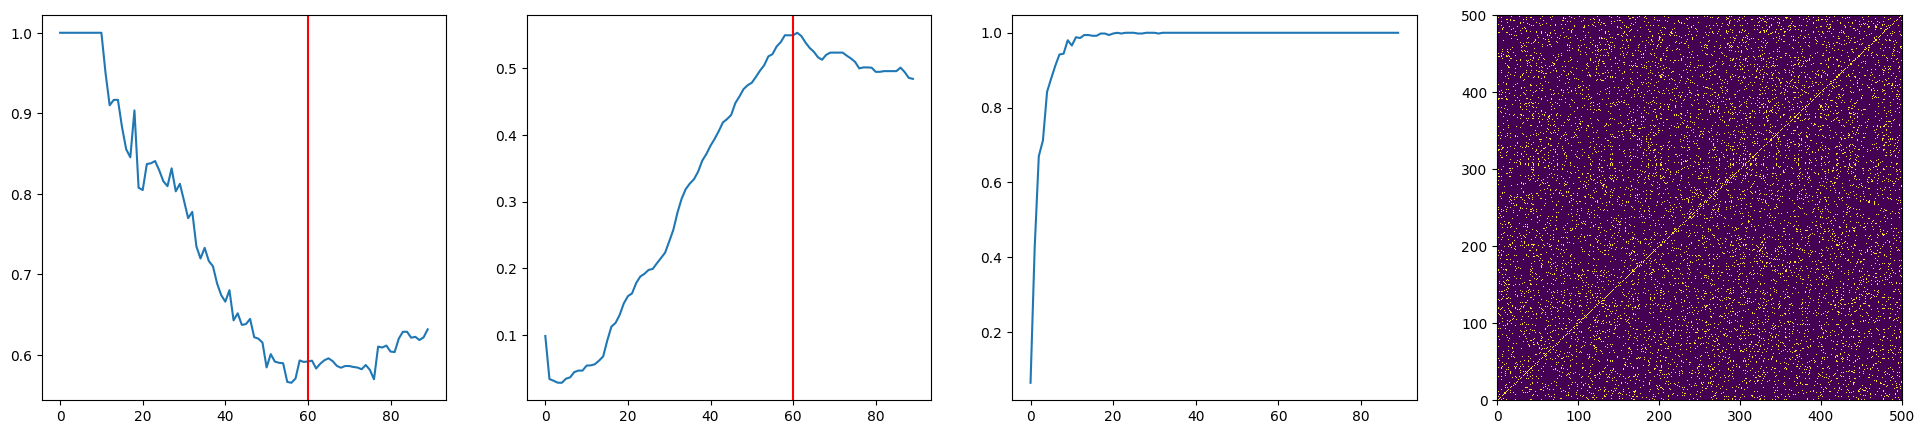

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
ax[0].plot(precisions); ax[0].axvline(60, color='r')
ax[1].plot(recalls); ax[1].axvline(60, color='r')
ax[2].plot(consistency)
ax[3].pcolormesh(module_c.recurrent_weights)

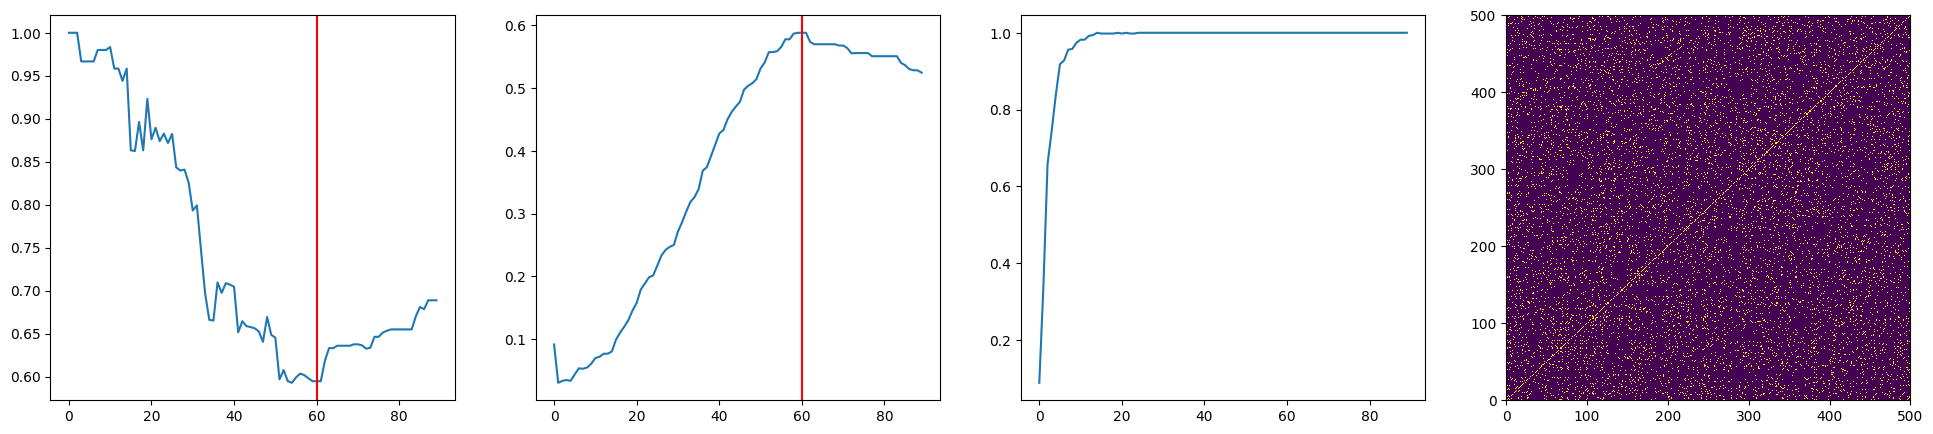

In [22]:
#[100]*100
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
ax[0].plot(precisions); ax[0].axvline(60, color='r')
ax[1].plot(recalls); ax[1].axvline(60, color='r')
ax[2].plot(consistency)
ax[3].pcolormesh(module_c.recurrent_weights)

/var/folders/b9/8km7dn7s35bfc4y81hgxnfj9d52_hx/T/ipykernel_38299/952859192.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  label_assignments = torch.tensor(label_counts).T[l]


IndexError: index 0 is out of bounds for dimension 0 with size 0

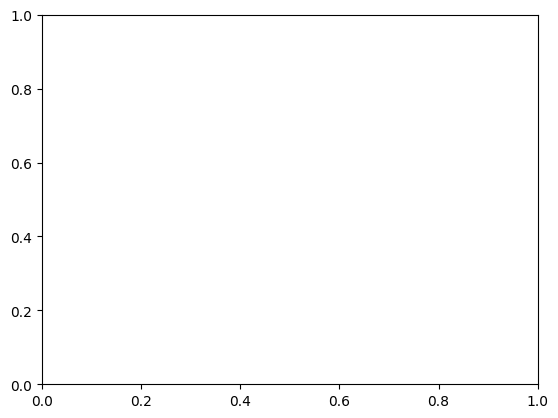

In [18]:
all_labels = module_d.labels(10)
label_counts = []
for row in module_c.connections.T:
    idxs = row.nonzero().flatten()
    if len(idxs) > 2:
        row_label_count = torch.empty(10, dtype=int)
        row_labels = all_labels[idxs]
        labels, counts = torch.unique(row_labels, return_counts=True)
        row_label_count[labels] = counts
        label_counts.append(row_label_count.tolist())
fig, ax = plt.subplots()
bottom = torch.zeros(len(label_counts))
for l in range(10):
    label_assignments = torch.tensor(label_counts).T[l]
    ax.bar(range(len(label_counts)), label_assignments.tolist(), label=str(l), bottom=bottom.tolist())
    bottom += label_assignments
plt.legend()

In [54]:
train_size = 30000
degrees = []

for epoch in range(100, 600, 100):
    degree = []
    
    beta = 1 - (1/epoch)
    module_d = DiscriminationModule(500, DatasetInitializer(dataset=mnist_data, num_classes=10), beta=beta)
    module_c = ClassificationModule(500, IdentityInitializer())
    
    for epoch_number in tqdm(range(train_size//epoch), desc=str(epoch)):
        for x in loader(epoch):
            y_ = module_d(x)
            module_c(y_)
        
        module_d.organize()
        module_c.organize()
        degree.append(torch.sum(module_c.recurrent_weights).item())
    
    degrees.append(degree)

500: 100%|██████████| 60/60 [1:06:05<00:00, 66.09s/it]


Text(0.5, 0, 'Organize interval')

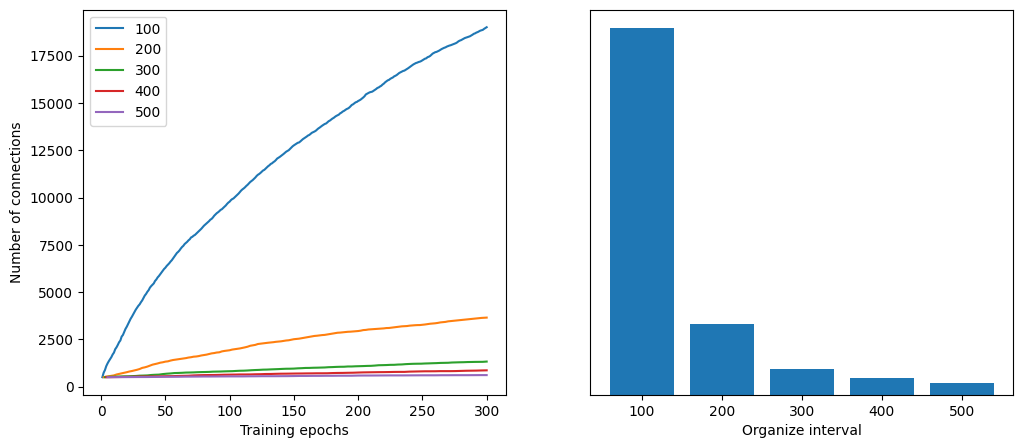

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(5):
    x = [*range(i+1, 30000//100+1, i+1)]
    ax[0].plot(x, degrees[i], label=str(100*(i+1)))
plt.sca(ax[0])
plt.legend()
plt.xlabel("Training epochs")
plt.ylabel("Number of connections")

ax[1].bar(range(5), [x[-1] for x in degrees])
plt.sca(ax[1])
plt.xticks(range(5), range(100, 600, 100))
plt.yticks([])
plt.xlabel("Organize interval")

In [3]:
from torch.utils.data import DataLoader, Dataset, RandomSampler
import transformations
from transformations import Scale, PadLabel, ToVector
from loading import SequentialLoader

transform = transformations.Compose([Scale(), PadLabel(10), ToVector()])
loader = SequentialLoader(mnist_data, transform)

for s in loader(20):
    print(s.shape, s[0,784:])

torch.Size([1, 794]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
torch.Size([1, 794]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
torch.Size([1, 794]) tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
torch.Size([1, 794]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([1, 794]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
torch.Size([1, 794])

In [4]:
from initialization import DatasetInitializer
initializer = DatasetInitializer(mnist_data, transform)
print(initializer.weights(500).shape)

torch.Size([794, 500])


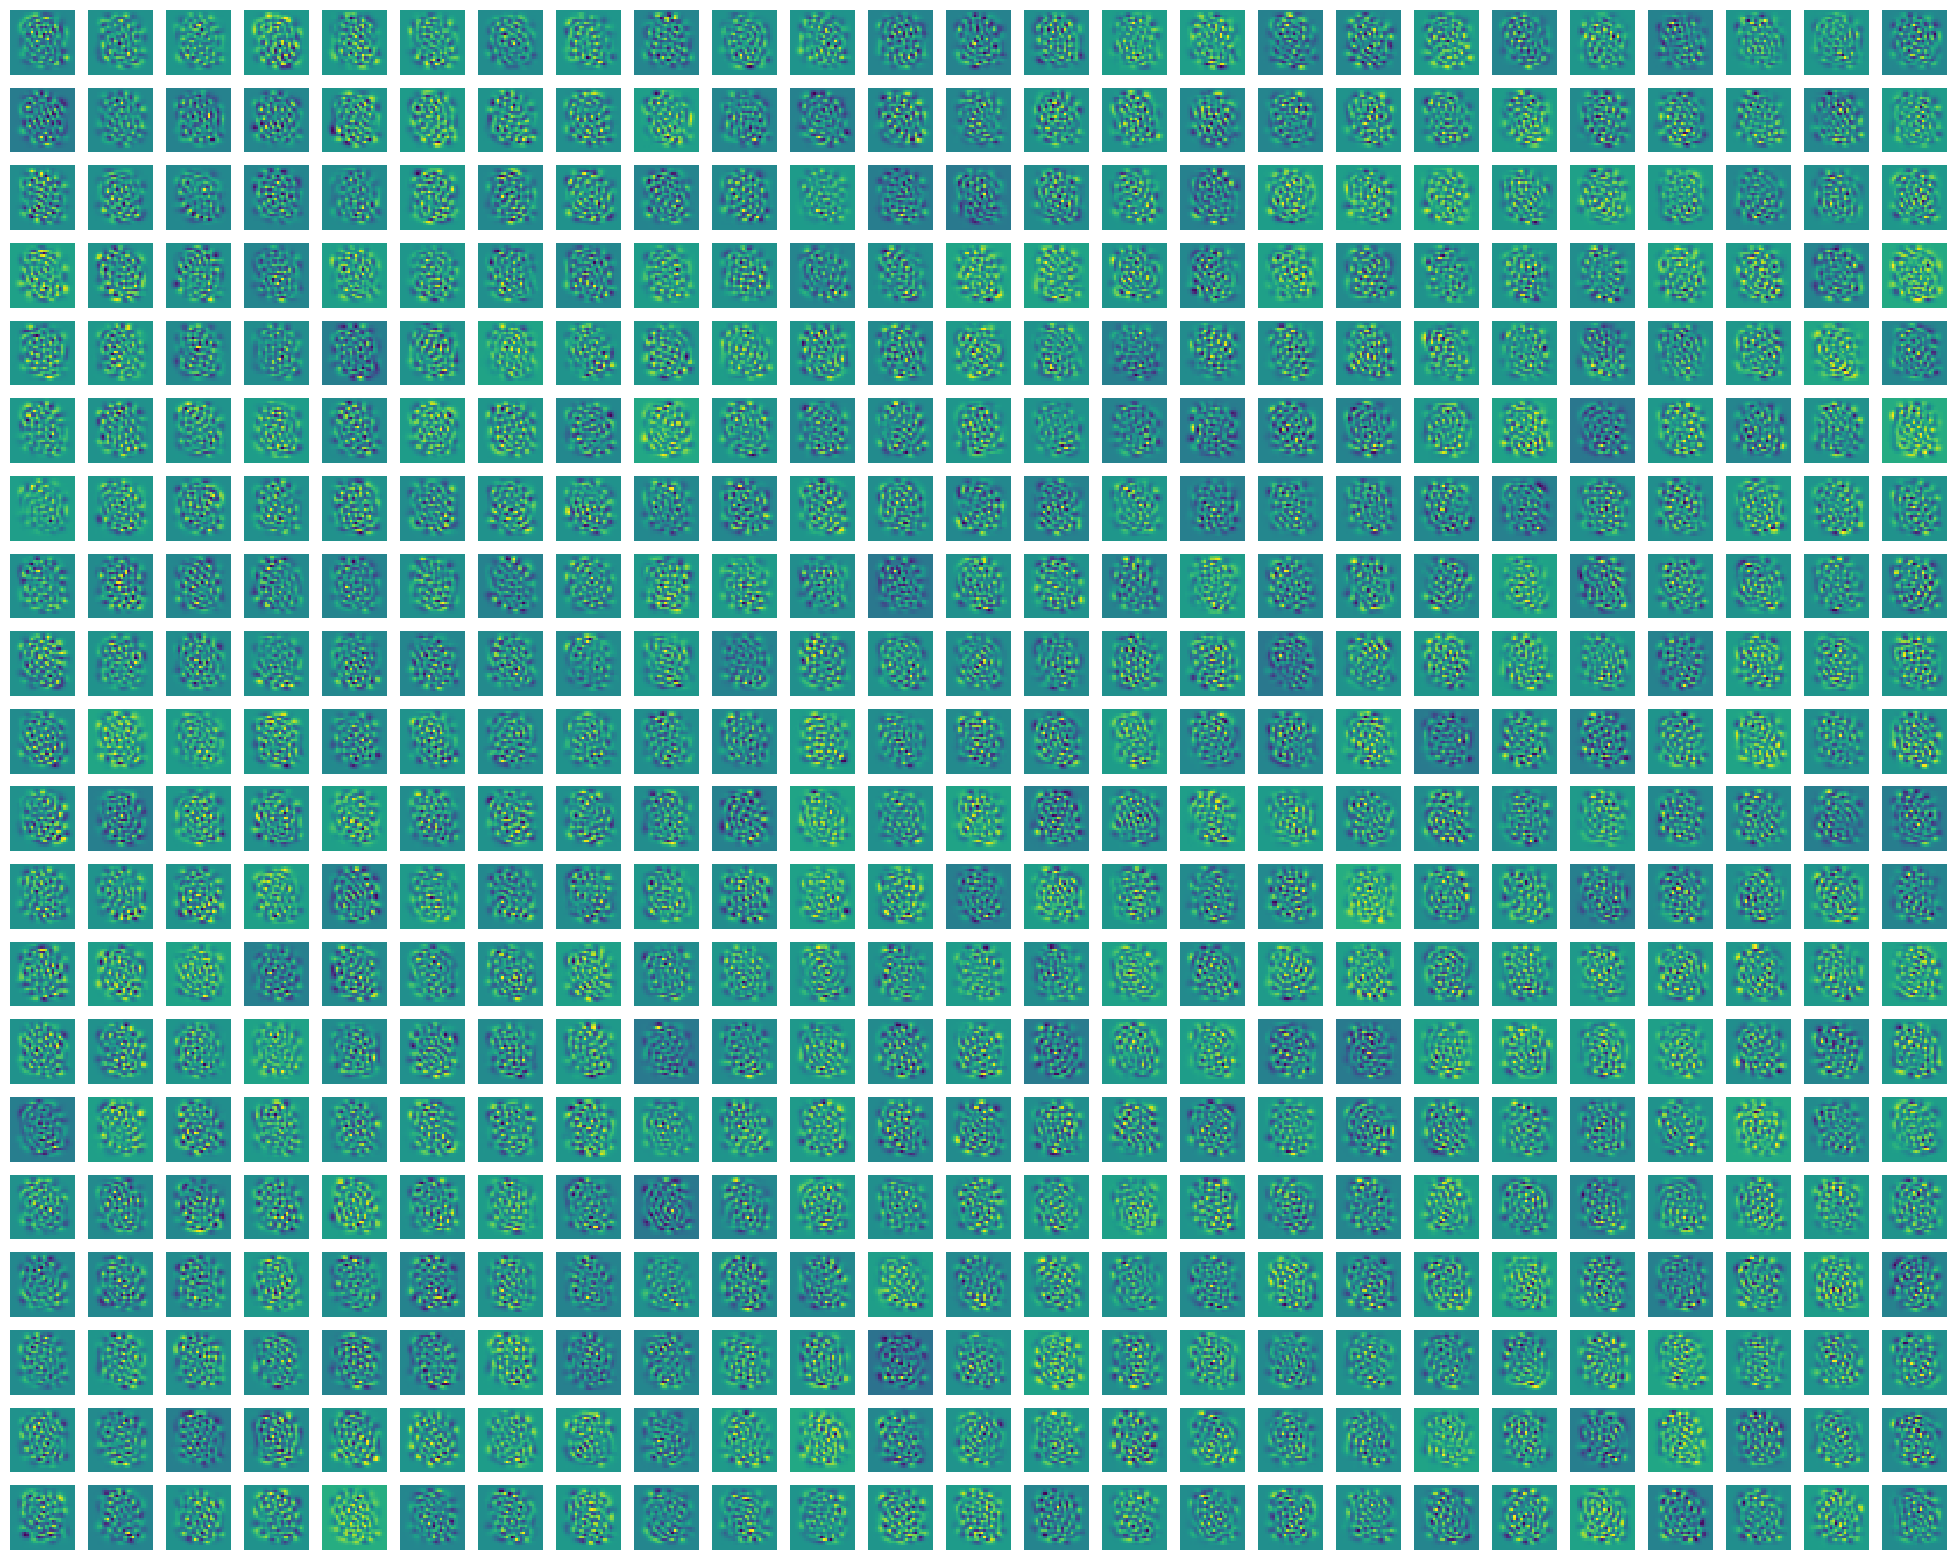

In [5]:
from plotting import plot_connections
plot_connections(initializer.weights(500)[:784,:])